### Model

We consider in this example are the following reactions:

- Forward reaction 1: A $\rightarrow$ B with time constant k<sub>1, fw</sub>

- Backward reaction 1: B $\rightarrow$ A with time constant k<sub>1, bw</sub>

- Forward reaction 2: B $\rightarrow$ C with time constant k<sub>2</sub>

Which gives the following differential equations according to the law of mass action:

$$\frac{dA}{dt} = k_{1,bw}[B] - k_{1,fw}[A]$$

$$\frac{dB}{dt} = k_{1,fw}[A] - k_{1,bw}[B] - k_{2}[B]$$

$$\frac{dC}{dt} = k_{2}[B]$$

This system of differential equation will be computed at a given time t using the following function:

In [1]:
def derivatives(y, t, p):
    
    """ Calculates the derivatives of the concentrations at t
    
    Used scipy.integrate.odeint to numerically solve the differential
    equations in a given time range.
    
    Lists (y and dy) used by scipy.integrate.odeint are converted
    to dictionaries (c and dc) in order to make the differentials
    easier to write and read for humans.
    
    Arguments:
        y (list): concentration values at t
        t (float): time value where the derivatives are calculated
        p (dict): dictionary containing the parameters used to
        calculate the derivatives e.g. time constants
    """
    
    # list (y) to dict (c) conversion
    c = {"A" : y[0], "B" : y[1], "C" : y[2]}
    
    # calculate the differentials
    dc = dict()
    dc["A"] = p["k_1bw"]*c["B"] - p["k_1fw"]*c["A"]
    dc["B"] = p["k_1fw"]*c["A"] - p["k_1bw"]*c["B"] - p["k_2"]*c["B"]
    dc["C"] = p["k_2"]*c["B"]
    
    # dict (dc) to list (dy) conversion
    dy = [dc["A"], dc["B"], dc["C"]]

    return dy

**Note:** when defining the "derivatives" function, do not use keys for the "p" parameters dictionary containing the string "c0_" (if you do an error will be raised). These keys are reserved for the initial concentrations and will be defined and used in the "fit.fit_dataset" function.

### Loading and plotting the dataset

The dataset "data/concentrations vs time.csv" is loaded in an object of class data_processing.Dataset (see [class documentation](#TODO add link) for details on the parameters that can be passed to this class). This object stores the raw data and the fit results and makes these parameters easy to access.

Its a good idea to consult the [recomendations for the .csv files format] (#TODO write and add link).

In [2]:
from chemical_kinetics import data_processing

ds = data_processing.Dataset(
    files_c = ["data/concentrations vs time.csv"],
    t_label = "Time [a.u.]",
    c_label = "Concentration [a.u.]"
)

You can check if the data was loaded properly by plotting it:

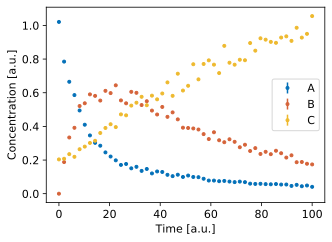

In [3]:
from chemical_kinetics import plot

plot.plot_c(ds)

### Fitting

We already defined the derivatives to be used by the fit in the derivatives function above. However, we also need to provide an initial guess for the time constants. In this case only time constant are parameters of the "residuals" function but a different residuals definition can include other parameters.

These parameters are given as a dictionary where the keys are the time constant names. The corresponding values are a dictionary containing the parameter arguments (for a list of arguments consult the lmfit.Parameter [documentation](#TODO: add link)).

In [4]:
parameters = {
    "k_1fw": dict(value = 0.1, min = 0),
    "k_1bw": dict(value = 0.1, min = 0),
    "k_2": dict(value = 0.1, min = 0)
}

Another argument to be passed to the fit function are the initial concentrations. These are defined in a similar way as the "parameters" variable since they are also fit parameters. It is mandatory to give the same names for theses parameters as the corresponding names given to the columns in the .csv file that was loaded in your dataset object. If you do not declare a value for the initial concentration for one of the species tracked in your .csv file then this value will be the first concentration value from this file by default.

For demonstration, in this example we consider that:
- the initial concentration of A is at least 0.5 and we default its initial value
- the initial concentration of B is known and fixed to 0
- the initial concentration of C is unknown and we use a default value for this parameter by not declaring it at all. The default value is the initial concentration for C in the dataset

In [5]:
c0 = {
    "A": dict(min = 0.5),
    "B": dict(value = 0., vary = False)
}

We can now pass these parameters to the fit function. Once the fit converged a message generated by the lmfit.MinimizerResult class is displayed (see [this page](#TODO add link) for details on this message significance).

In [6]:
from chemical_kinetics import fit

fit.fit_dataset(
    dataset = ds,
    derivatives = derivatives,
    parameters = parameters,
    c0 = c0
)

Fit succeeded.


The fit results can be printed and plotted using the following functions:

In [7]:
fit.print_result(ds)

,name,value,stderr,stderr/value %,init. val.,vary,min,max
0,k_1fw,0.102,0.00191,1.87,0.1,True,0.0,inf
1,k_1bw,0.0204,0.000606,2.96,0.1,True,0.0,inf
2,k_2,0.0201,0.000204,1.01,0.1,True,0.0,inf
3,c0_A,1.0,0.00749,0.747,1.02,True,0.5,inf
4,c0_B,0.0,0.0,nan,0.0,False,-inf,inf
5,c0_C,0.205,0.00443,2.16,0.204,True,-inf,inf


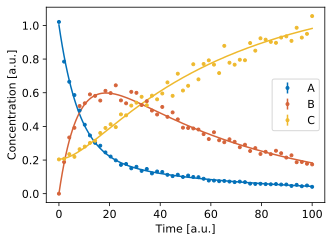

In [8]:
from chemical_kinetics import plot
plot.plot_c(ds)

In [9]:
from chemical_kinetics import fit
import pandas as pd
import numpy as np
import lmfit

params = lmfit.Parameters()
params.add("k_1fw", value = 0.1)
params.add("k_1bw", value = 0.02)
params.add("k_2", value = 0.02)
params.add("c0_A", value = 1)
params.add("c0_B", value = 0)
params.add("c0_C", value = 0.2)

t = np.linspace(0,100,50)
c = fit.evaluate(derivatives, params, t)

noise = lambda c : c + c*0.2*(np.random.random(c.shape) - 0.5)
c = noise(c)

data = np.hstack((t.reshape(-1,1), c))

df = pd.DataFrame(columns = ["t", "A", "B", "C"], data = data)

df.to_csv(r"data/concentrations vs time.csv", index = False)